# 1. Introduction

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import *
from keras.layers import *
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, VGG19
from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')

In [2]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])


# 2. Data preparation
## 2.1 Load and review data

In [3]:
# Load the data
df = pd.read_json("../Dataset/labels.json")
print(df)

    filename  people
0      0.jpg       2
1     60.jpg       0
2    120.jpg       1
3    180.jpg       1
4    240.jpg       1
5    300.jpg       0
6    360.jpg       1
7    420.jpg       0
8    480.jpg       1
9    540.jpg       2
10   600.jpg       1
11   660.jpg       1
12   720.jpg       0
13   780.jpg       0
14   840.jpg       1
15   900.jpg       1
16   960.jpg       1
17  1020.jpg       1
18  1080.jpg       1
19  1140.jpg       2
20  1200.jpg       0
21  1260.jpg       0
22  1320.jpg       2
23  1380.jpg       2
24  1440.jpg       2
25  1500.jpg       4
26  1560.jpg       2
27    30.jpg       0
28    90.jpg       1
29   150.jpg       2
30   210.jpg       1
31   270.jpg       0
32   330.jpg       1
33   390.jpg       1
34   450.jpg       0
35   510.jpg       3
36   570.jpg       3
37   630.jpg       2
38   690.jpg       0
39   750.jpg       0
40   810.jpg       1
41   870.jpg       0
42   930.jpg       2
43   990.jpg       1
44  1050.jpg       1
45  1110.jpg       3
46  1170.jpg 

In [4]:
# Not needed for now
# Map each id to its appropriate file name
#df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

In [5]:
df.describe()

,people
count,54.000000
mean,1.203704
std,1.034857
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


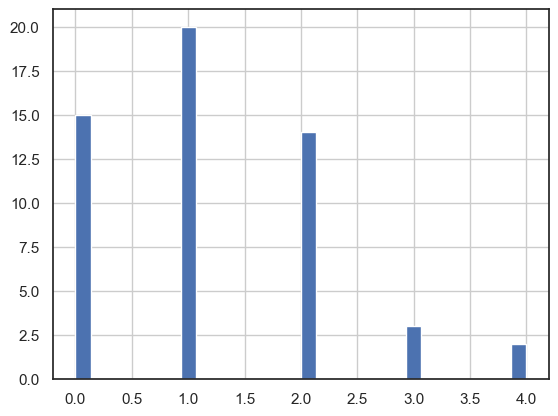

In [6]:
df['people'].hist(bins=30);

## 2.2 Setup data generator with optional augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

The approaches can help avoid overfitting, but it is not clear that we *want* to add this extra variance in this specific problem. You can play with the optional augmentations below and see how they affect the results.

In [7]:
# Setup some constants
size = 224
batch_size = 64

In [8]:
# ImageDataGenerator - with defined augmentaions
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixels to [0,1]. This seems to work well with pretrained models.
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
#     rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
#     zoom_range = 0.2, # Randomly zoom image 
#     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    validation_split=0.2,  # 20% of data randomly assigned to validation
    
    # This one is important:
    preprocessing_function=resnet50.preprocess_input,  # Whenever working with a pretrained model, it is said to be essential to use its provided preprocess
)

## 2.3 Load image data
We use the defined ImageDataGenerator to read the images using the dataframe we read earlier.

In [9]:
flow_params = dict(
    dataframe=df,
    directory='../Dataset',
    x_col="filename",
    y_col="people",
    weight_col=None,
    target_size=(size, size),
    color_mode='rgb',
    class_mode="raw",
    batch_size=batch_size,
    shuffle=True,
    seed=0,
)

# The dataset is split to training and validation sets at this point
train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 44 validated image filenames.
Found 10 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

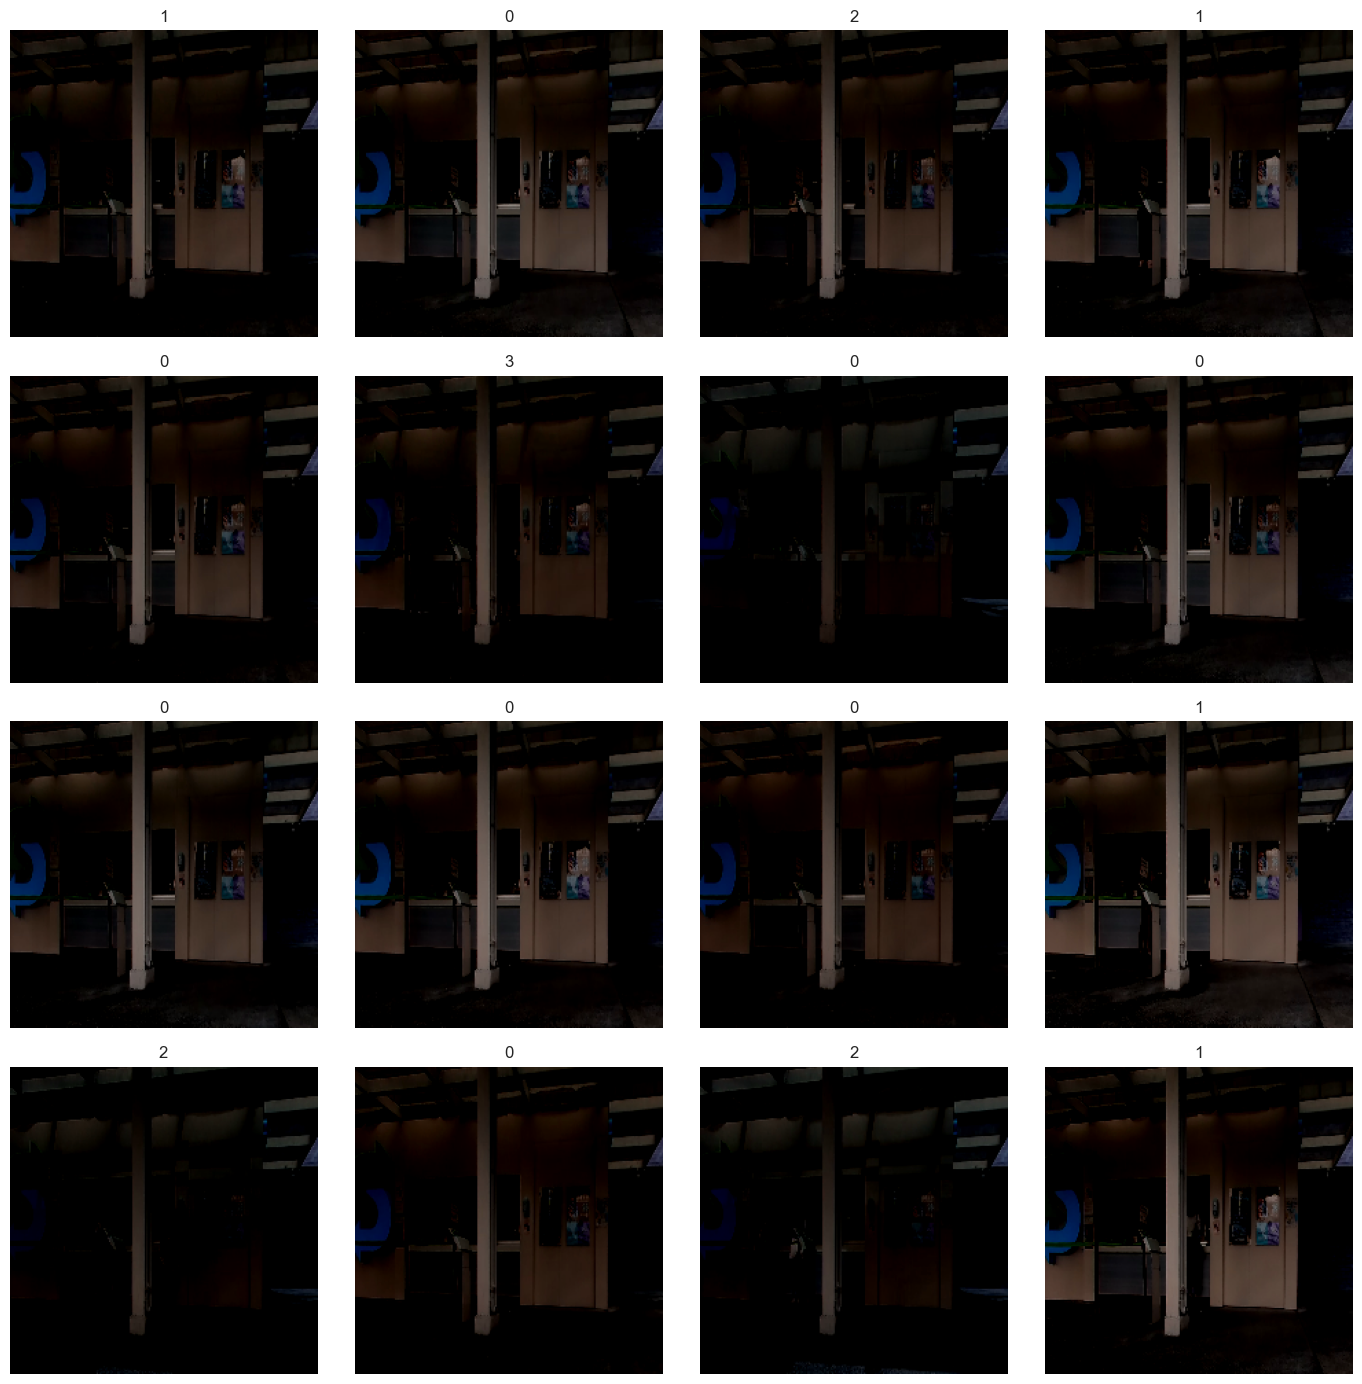

In [10]:
batch = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(batch[0][i])
    ax.axis('off')
    ax.set_title(batch[1][i])
plt.tight_layout()
plt.show()

# 3. CNN
## 3.1 Load and modify the pretrained model

I used the Keras implementation of ResNet50 - a convolutional neural network that is 50 layers deep.

It was initially applied to image recognition tasks, i.e. classification, but can be modified to be used for regression problems, like this case.

In [11]:
base_model1 = resnet50.ResNet50(
    weights='imagenet',  # Load the pretrained weights, trained on the ImageNet dataset.
    include_top=False,  # We don't include the fully-connected layer at the top of the network - we need to modify the top.
    input_shape=(size, size, 3),  # 224x224 was the original size ResNet was trained on, so I decided to use this.
    pooling='avg',  # A global average pooling layer will be added after the last convolutional block.
)

In [12]:
base_model1.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# Here we change the top (the last parts) of the network.
x = base_model1.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [14]:
model1 = Model(inputs=base_model1.input, outputs=predictions)

In [15]:
k = -7
for layer in model1.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model1.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [16]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 3,153,921 (12.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

## 3.2 Set the optimizer and annealer

In [17]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [18]:
# Compile the model
model1.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [19]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [20]:
# Fit the model
history1 = model1.fit(
    x=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/50


c:\Users\mymat\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 - 11s - 11s/step - loss: 5.0016 - mean_absolute_error: 1.9598 - mean_squared_error: 5.0016 - val_loss: 11.8745 - val_mean_absolute_error: 3.3741 - val_mean_squared_error: 11.8745 - learning_rate: 0.0010
Epoch 2/50
1/1 - 3s - 3s/step - loss: 50.7093 - mean_absolute_error: 7.0347 - mean_squared_error: 50.7093 - val_loss: 3.2901 - val_mean_absolute_error: 1.6744 - val_mean_squared_error: 3.2901 - learning_rate: 0.0010
Epoch 3/50
1/1 - 3s - 3s/step - loss: 6.3466 - mean_absolute_error: 2.3207 - mean_squared_error: 6.3466 - val_loss: 0.8128 - val_mean_absolute_error: 0.7676 - val_mean_squared_error: 0.8128 - learning_rate: 0.0010
Epoch 4/50
1/1 - 3s - 3s/step - loss: 3.4977 - mean_absolute_error: 1.5491 - mean_squared_error: 3.4977 - val_loss: 4.4144 - val_mean_absolute_error: 1.9800 - val_mean_squared_error: 4.4144 - learning_rate: 0.0010
Epoch 5/50
1/1 - 3s - 3s/step - loss: 10.9496 - mean_absolute_error: 3.1385 - mean_squared_error: 10.9496 - val_loss: 5.8314 - val_mean_absolute_erro

In [21]:
base_model_VGG16 = vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(size, size, 3),
    pooling='avg',
)

In [22]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG16.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [23]:
model2 = Model(inputs=base_model_VGG16.input, outputs=predictions)

In [24]:
k = -7
for layer in model2.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model2.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense_2
dense_3


In [25]:
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

## 3.2 Set the optimizer and annealer

In [26]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [27]:
# Compile the model
model2.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [28]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [29]:
# Fit the model
history2 = model2.fit(
    x=train_generator,
    epochs=40,  # 40 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/40
1/1 - 9s - 9s/step - loss: 1.8249 - mean_absolute_error: 1.0681 - mean_squared_error: 1.8249 - val_loss: 277.0312 - val_mean_absolute_error: 16.6273 - val_mean_squared_error: 277.0312 - learning_rate: 0.0010
Epoch 2/40
1/1 - 6s - 6s/step - loss: 255.4670 - mean_absolute_error: 15.9347 - mean_squared_error: 255.4670 - val_loss: 0.5566 - val_mean_absolute_error: 0.5919 - val_mean_squared_error: 0.5566 - learning_rate: 0.0010
Epoch 3/40
1/1 - 6s - 6s/step - loss: 1.1770 - mean_absolute_error: 0.8559 - mean_squared_error: 1.1770 - val_loss: 0.6891 - val_mean_absolute_error: 0.7178 - val_mean_squared_error: 0.6891 - learning_rate: 0.0010
Epoch 4/40
1/1 - 6s - 6s/step - loss: 1.7865 - mean_absolute_error: 1.0563 - mean_squared_error: 1.7865 - val_loss: 0.5017 - val_mean_absolute_error: 0.5832 - val_mean_squared_error: 0.5017 - learning_rate: 0.0010
Epoch 5/40
1/1 - 6s - 6s/step - loss: 1.4015 - mean_absolute_error: 0.9194 - mean_squared_error: 1.4015 - val_loss: 1.4654 - val_mean_

In [30]:
base_model_VGG19 = VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(size, size, 3),
    pooling='avg',
)

In [31]:
# Here we change the top (the last parts) of the network.
x = base_model_VGG19.output  # Since we used pooling='avg', the output is of the pooling layer
x = Dense(1024, activation='relu')(x)  # We add a single fully-connected layer
predictions = Dense(1, activation='linear')(x)  # This is the new output layer - notice only 1 output, this will correspond to the number of people in the image

In [32]:
model3 = Model(inputs=base_model_VGG19.input, outputs=predictions)

In [33]:
k = -7
for layer in model3.layers[:k]:
    layer.trainable = False
print('Trainable:')
for layer in model3.layers[k:]:
    print(layer.name)
    layer.trainable = True

Trainable:
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_1
dense_4
dense_5


In [34]:
model3.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,550,721 (78.39 MB)

 Trainable params: 7,605,761 (29.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

## 3.2 Set the optimizer and annealer

In [35]:
# Define the optimizer - this function will iteratively improve parameters in order to minimise the loss. 
# The Adam optimization algorithm is an extension to stochastic gradient descent, which is usually more effective and fast.
optimizer = Adam(
    # The most important parameter is the learning rate - controls the amount that the weights are updated during eache round of training.
    learning_rate=0.001,
    # Additional parameters to play with:
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
)

In [36]:
# Compile the model
model3.compile(
    optimizer=optimizer, 
    loss="mean_squared_error",  # This is a classic regression score - the lower the better
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [37]:
# Set a learning rate annealer - to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function. 
# The LR is decreased dynamically when the score is not improved. This keeps the advantage of the fast computation time with a high LR at the start.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',  # Track the score on the validation set
    patience=3,  # Number of epochs in which no improvement is seen.
    verbose=1, 
    factor=0.2,  # Factor by which the LR is multiplied.
    min_lr=0.000001  # Don't go below this value for LR.
)

In [38]:
# Fit the model
history3 = model3.fit(
    x=train_generator,
    epochs=50,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data=valid_generator,
    verbose=2, 
    callbacks=[learning_rate_reduction],
)
print('\nDone.')

Epoch 1/50
1/1 - 10s - 10s/step - loss: 3.8033 - mean_absolute_error: 1.6285 - mean_squared_error: 3.8033 - val_loss: 462.1139 - val_mean_absolute_error: 21.4819 - val_mean_squared_error: 462.1139 - learning_rate: 0.0010
Epoch 2/50
1/1 - 8s - 8s/step - loss: 424.2947 - mean_absolute_error: 20.5510 - mean_squared_error: 424.2947 - val_loss: 0.6871 - val_mean_absolute_error: 0.7151 - val_mean_squared_error: 0.6871 - learning_rate: 0.0010
Epoch 3/50
1/1 - 8s - 8s/step - loss: 1.7812 - mean_absolute_error: 1.0542 - mean_squared_error: 1.7812 - val_loss: 1.3637 - val_mean_absolute_error: 0.9346 - val_mean_squared_error: 1.3637 - learning_rate: 0.0010
Epoch 4/50
1/1 - 8s - 8s/step - loss: 2.8155 - mean_absolute_error: 1.2948 - mean_squared_error: 2.8155 - val_loss: 0.6325 - val_mean_absolute_error: 0.6904 - val_mean_squared_error: 0.6325 - learning_rate: 0.0010
Epoch 5/50
1/1 - 8s - 8s/step - loss: 1.7541 - mean_absolute_error: 1.0450 - mean_squared_error: 1.7541 - val_loss: 4.9244 - val_mea

# 4. Evaluate the model
## 4.1 Training and validation curves

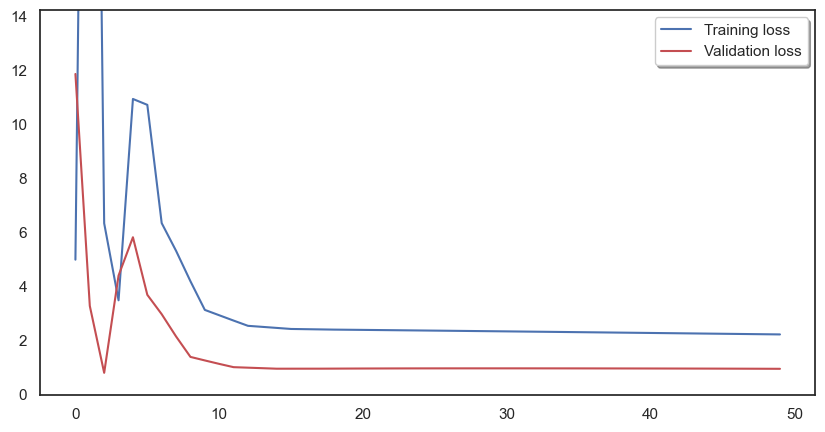

In [39]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history1.history['loss'], color='b', label="Training loss")
ax.plot(history1.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history1.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

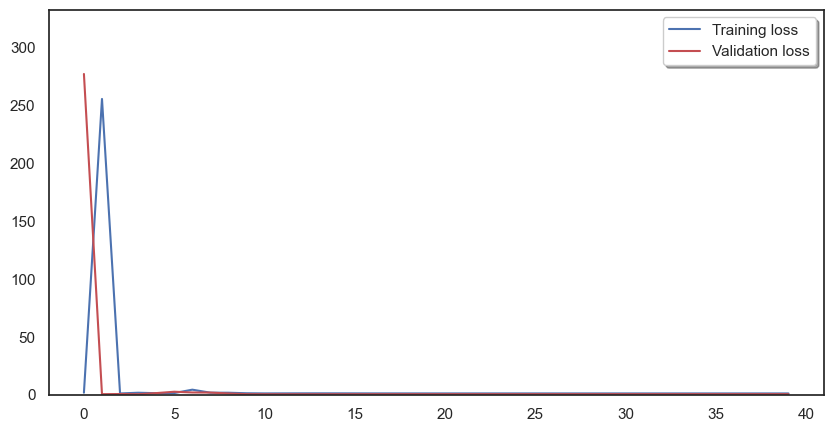

In [40]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history2.history['loss'], color='b', label="Training loss")
ax.plot(history2.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history2.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

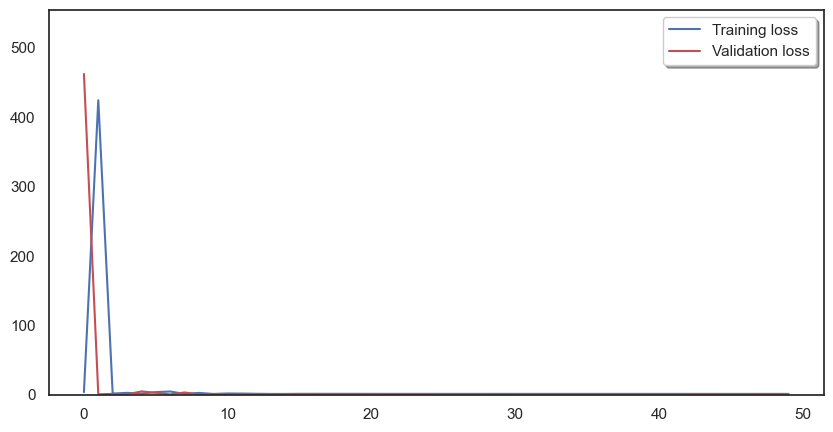

In [41]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history3.history['loss'], color='b', label="Training loss")
ax.plot(history3.history['val_loss'], color='r', label="Validation loss",axes =ax)
ax.set_ylim(top=np.max(history3.history['val_loss'])*1.2, bottom=0)
legend = ax.legend(loc='best', shadow=True)

In [42]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model1.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_resnet = np.concatenate(all_labels)
cat_pred_resnet = np.concatenate(all_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [43]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model2.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_vgg16 = np.concatenate(all_labels)
cat_pred_vgg16 = np.concatenate(all_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [44]:
# Predict on entire validation set, to be able to review the predictions manually
valid_generator.reset()
all_labels = []
all_pred = []
for i in range(len(valid_generator)):
    x = next(valid_generator)
    pred_i = model3.predict(x[0])[:,0]
    labels_i = x[1]
    all_labels.append(labels_i)
    all_pred.append(pred_i)
#     print(np.shape(pred_i), np.shape(labels_i))

cat_labels_vgg19 = np.concatenate(all_labels)
cat_pred_vgg19 = np.concatenate(all_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


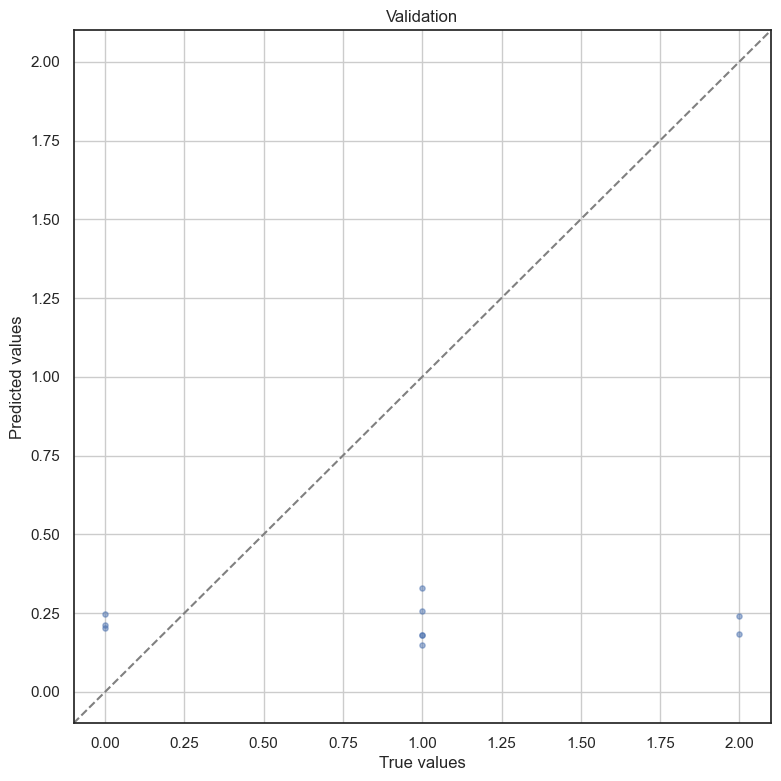

In [45]:
df_predictions_resnet = pd.DataFrame({'True values': cat_labels_resnet, 'Predicted values': cat_pred_resnet})
ax = df_predictions_resnet.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

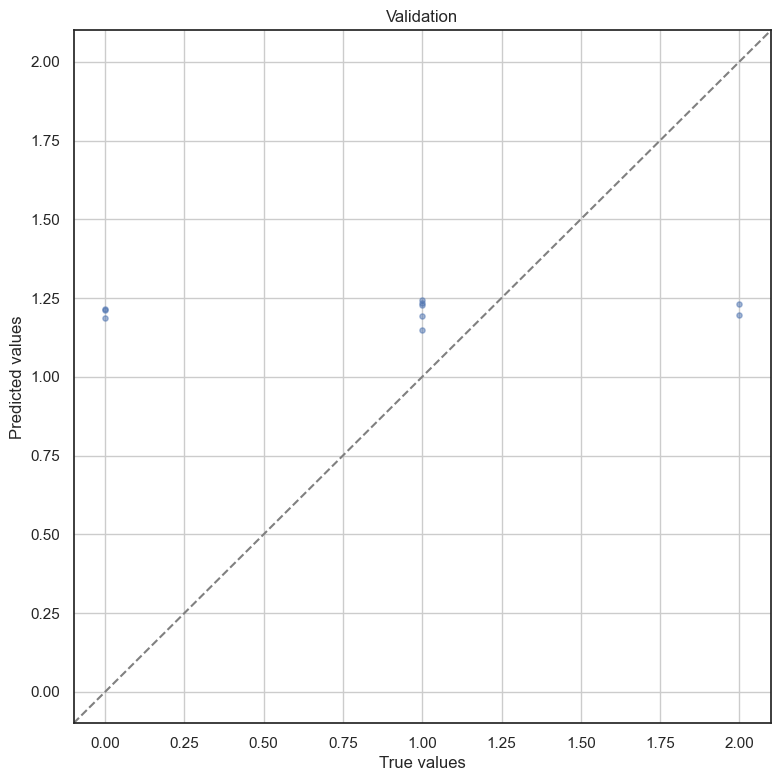

In [46]:
df_predictions_vgg16 = pd.DataFrame({'True values': cat_labels_vgg16, 'Predicted values': cat_pred_vgg16})
ax = df_predictions_vgg16.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

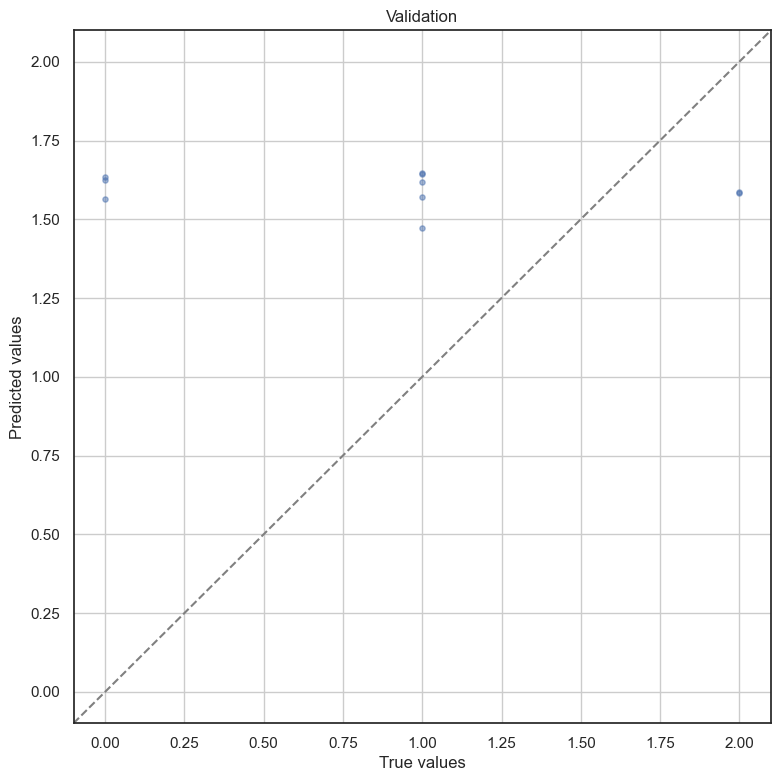

In [47]:
df_predictions_vgg19 = pd.DataFrame({'True values': cat_labels_vgg19, 'Predicted values': cat_pred_vgg19})
ax = df_predictions_vgg19.plot.scatter('True values', 'Predicted values', alpha=0.5, s=14, figsize=(9,9))
ax.grid(axis='both')
add_one_to_one_correlation_line(ax)
ax.set_title('Validation')

plt.show()

In [48]:
mse_resnet = mean_squared_error(*df_predictions_resnet.T.values)
pearson_r_resnet = sc.stats.pearsonr(*df_predictions_resnet.T.values)[0]

print(f'MSE: {mse_resnet:.1f}\nPearson r: {pearson_r_resnet:.1f}')

MSE: 1.0
Pearson r: -0.1


In [49]:
mse_vgg16 = mean_squared_error(*df_predictions_vgg16.T.values)
pearson_r_vgg16 = sc.stats.pearsonr(*df_predictions_vgg16.T.values)[0]

print(f'MSE: {mse_vgg16:.1f}\nPearson r: {pearson_r_vgg16:.1f}')

MSE: 0.6
Pearson r: 0.1


In [50]:
mse_vgg19 = mean_squared_error(*df_predictions_vgg19.T.values)
pearson_r_vgg19 = sc.stats.pearsonr(*df_predictions_vgg19.T.values)[0]

print(f'MSE: {mse_vgg19:.1f}\nPearson r: {pearson_r_vgg19:.1f}')

MSE: 1.0
Pearson r: -0.2


In [51]:
import cv2
import numpy as np
import os

# Directory containing the images
directory = '../Dataset'

# List to store the images
images = []

# Loop over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):  # Check if the file is an image
        # Load the image
        img = cv2.imread(os.path.join(directory, filename))
        # Append the image to the list
        images.append(img)

# Convert the list of images to a numpy array
images = np.array(images)

# Save the numpy array to a .npy file
np.save('../Dataset/images.npy', images)

ValueError: No model config found in the file at crowd_counting_resnet50_n.h5.

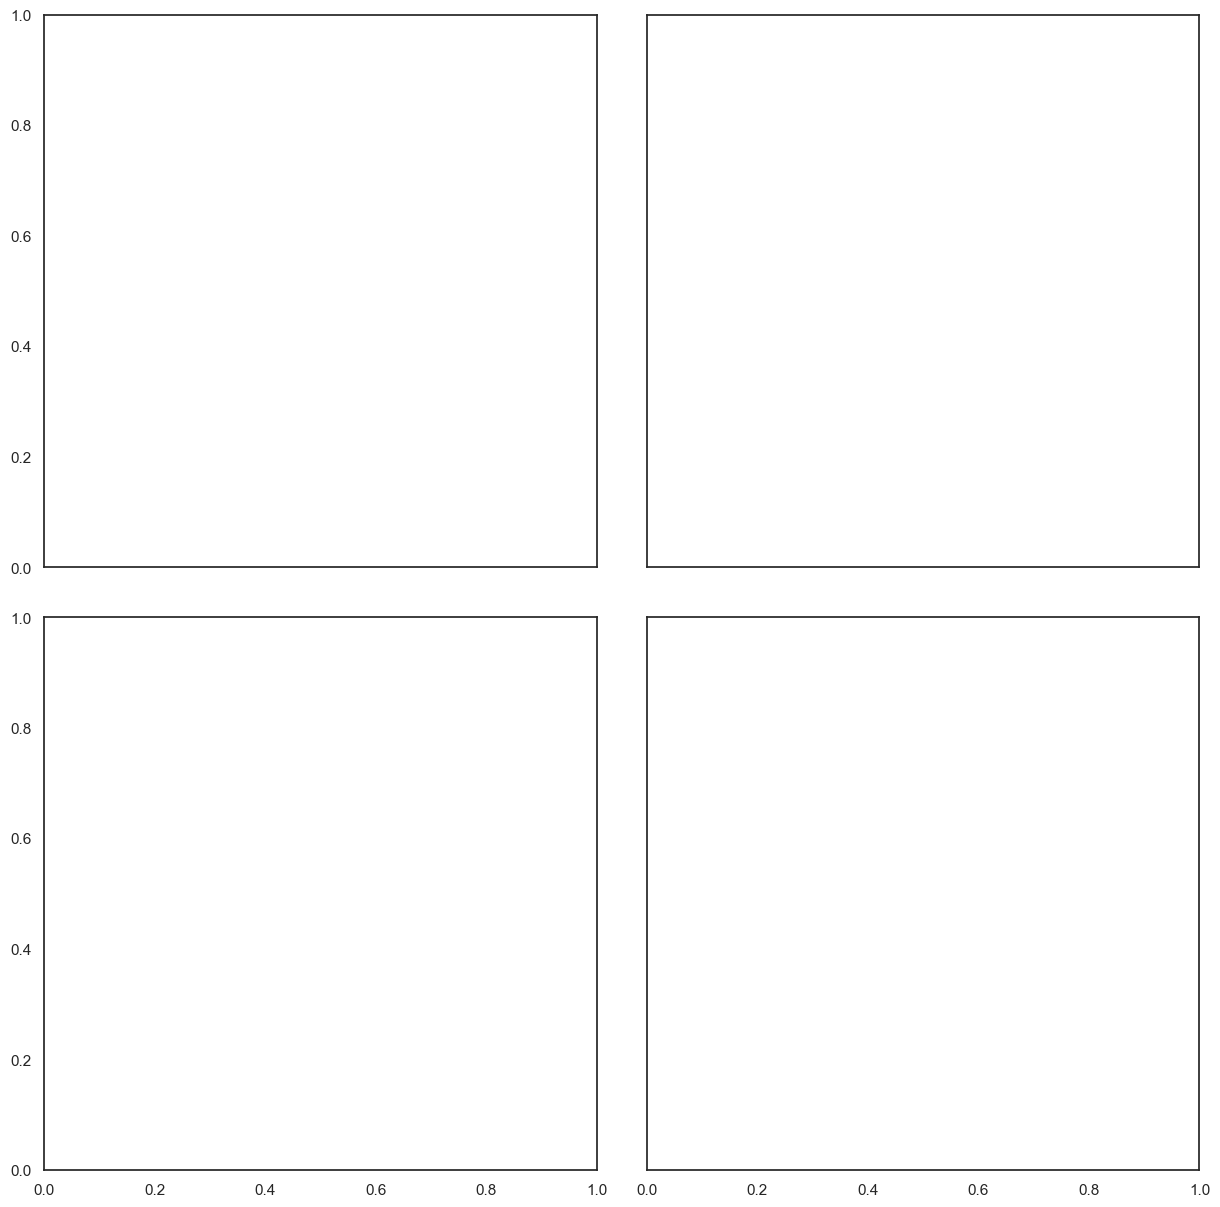

In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
labels = np.array(df['people'])
# set figure size
img = np.load('../Dataset/images.npy')
fig = plt.figure(figsize=(15,15))
grid = ImageGrid(
        fig, 111,
        nrows_ncols=(2,2),
        axes_pad=0.5
)

# Load the pre-trained ResNet50 model
model = load_model('crowd_counting_resnet50_n.h5')
for x in range(0, 4):
      y = 0

# Load an image for crowd counting
      img1 = cv2.imread('%d.jpg'%(y))
      #a = "sweet %s %d" % ( aaa , bbb)
      img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
      m=img1
# Resize the image to the input size required by the model
      img1 = cv2.resize(img1, (224, 224))

# Scale the pixel values to be in the range of [0, 1]
      img1 = img1 / 255.0

# Expand the dimensions of the image to match the input shape required by the model
      img1 = np.expand_dims(img1, axis=0)

# Make a prediction on the image using the pre-trained model
      pred = model.predict(img1)

# The output of the model is a density map, so to get the actual count of people in the image,
# we need to sum up the pixel values in the density map and then round off to the nearest integer
      count = int(round(np.sum(pred)))
     
      title1 = 'actual count => ' + str(labels[x])
      title2 = 'predict count => ' + str(count)
      full_title = title1 + '\n' + title2
      grid[x].set_title(full_title)
      
      grid[x].imshow(img[x])
      y = y + 30